<a href="https://colab.research.google.com/github/s4582621/s4582621.github.io/blob/master/Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment 3 --> *Question 2*

Animal Classifier based on Duck Duck Go algorithim to Web scrape images

Animals:
- Bird
- Dog
- Cat
- Mouse
- Snake
- Lion
- Tiger
- Panda
- Elephant
- Giraffe

Make sure that all Kaggel libraries are up to date and properly installed:

In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

In [3]:
!pip install -Uqq duckduckgo_search
!pip install -Uqq fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.27.1, but you have requests 2.30.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.9 MB/s eta 0:00:00
     

In [4]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastbook import search_images_ddg

#def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

Begin our animal photo search (test fetching of each animal type). This was done iteratively for each defined animal above.

In [18]:
urls = search_images_ddg('bird photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg?cs=srgb&dl=pexels-roshan-kamath-1661179.jpg&fm=jpg'

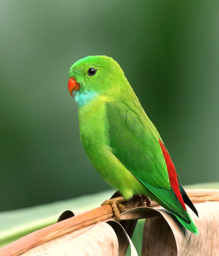

In [19]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Create folders holding 200 photos of each type of animal for algorithim training:

In [7]:
searches = 'giraffe','elephant','panda','tiger','lion','snake','mouse','cat','dog','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images_ddg(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images_ddg(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Remove any links which could cause errors during algorithim training:

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

254

Create training sets for each animal class using a datablock:

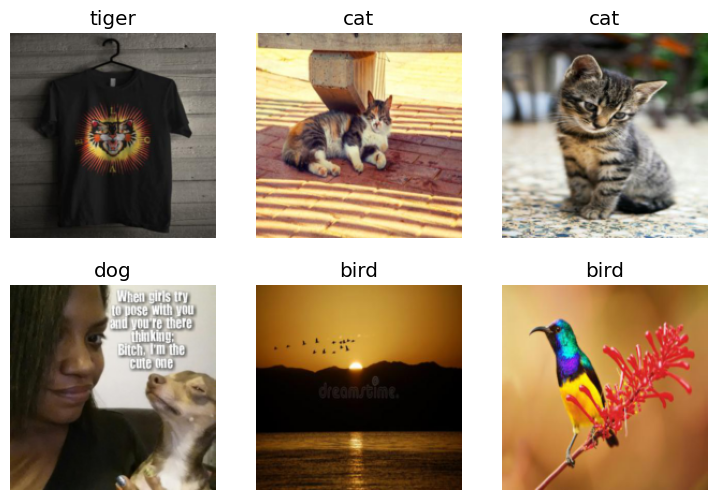

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

The algorithim required for for training needs to be downloaded. For animal image classification, the algorithim used will be an 18 layer ResNET model. This model can be trained using the datablock created above. By finetuning the weights of the top 3 layers, performance is optimized.

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 209MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.347930,0.602398,0.174387,00:35


epoch,train_loss,valid_loss,error_rate,time
0,0.612036,0.501386,0.147139,00:30
1,0.354728,0.494925,0.139873,00:31
2,0.178108,0.491397,0.135332,00:30


Lets test the model on each specific animal class. Each image class can be accessed by the order in which the folders where produced to store the images (e.g dog is the third folder, therefore to access it we call
probs[2]).

In [20]:
# Bird
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9997


In [ ]:
# Dog
is_dog,_,probs = learn.predict(PILImage.create('dog.jpg'))
print(f"This is a: {is_dog}.")
print(f"Probability it's a dog: {probs[2]:.4f}")

This is a: dog.
Probability it's a dog: 0.9998


In [ ]:
# Cat
is_cat,_,probs = learn.predict(PILImage.create('cat.jpg'))
print(f"This is a: {is_cat}.")
print(f"Probability it's a cat: {probs[1]:.4f}")

This is a: cat.
Probability it's a cat: 0.9982


In [ ]:
# Mouse
is_mouse,_,probs = learn.predict(PILImage.create('mouse.jpg'))
print(f"This is a: {is_mouse}.")
print(f"Probability it's a mouse: {probs[6]:.4f}")

This is a: mouse.
Probability it's a mouse: 1.0000


In [ ]:
# Snake
is_snake,_,probs = learn.predict(PILImage.create('snake.jpg'))
print(f"This is a: {is_snake}.")
print(f"Probability it's a snake: {probs[8]:.4f}")

This is a: snake.
Probability it's a snake: 0.9999


In [ ]:
# Lion
is_lion,_,probs = learn.predict(PILImage.create('lion.jpg'))
print(f"This is a: {is_lion}.")
print(f"Probability it's a lion: {probs[5]:.4f}")

This is a: lion.
Probability it's a lion: 1.0000


In [ ]:
# Tiger
is_tiger,_,probs = learn.predict(PILImage.create('tiger.jpg'))
print(f"This is a: {is_tiger}.")
print(f"Probability it's a tiger: {probs[9]:.4f}")

This is a: tiger.
Probability it's a tiger: 1.0000


In [ ]:
# Panda
is_panda,_,probs = learn.predict(PILImage.create('panda.jpg'))
print(f"This is a: {is_panda}.")
print(f"Probability it's a panda: {probs[7]:.4f}")

This is a: panda.
Probability it's a panda: 1.0000


In [17]:
# Elephant
is_elephant,_,probs = learn.predict(PILImage.create('elephant.jpg'))
print(f"This is a: {is_elephant}.")
print(f"Probability it's a elephant: {probs[3]:.4f}")

This is a: elephant.
Probability it's a elephant: 1.0000


In [12]:
# Giraffe
is_giraffe,_,probs = learn.predict(PILImage.create('giraffe.jpg'))
print(f"This is a: {is_giraffe}.")
print(f"Probability it's a giraffe: {probs[4]:.4f}")

This is a: giraffe.
Probability it's a giraffe: 1.0000


For each animal class, the classification accuracy of the model was 99% or greater. The performance can be measured quantitatively through additional metrics as required

Fastai automatically choses a categorical loss function when it isn't specified. Hence, because the code above is modelled based on the example from notebook00, this is loss function which gets used in the background. This function is also known as the categorical crossentropy function which computes the loss between true labels and predicted labels. Becauese if this, it works in both binary and mult-class instances, but is primarily used for multi-class classification. This makes it ideal for this specific image classifier which has 10 defined animal classes.

*Confusion Matrix*:

In [13]:
from fastbook import *
from fastai.vision.widgets import *

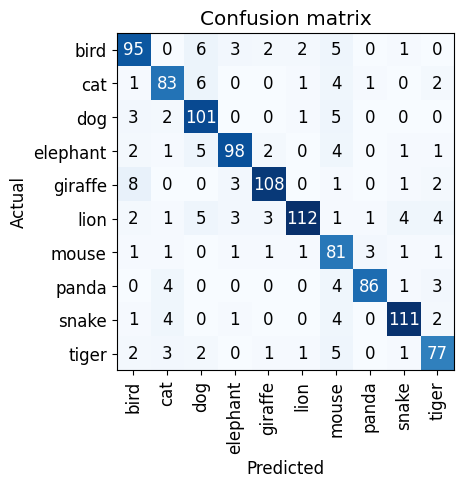

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The confusion matrix provides a visual representation of the classification accuracy of the ResNET algorithim. For all classes majority of the images were correctly identified. For almost every class however, there were images which were incorrectly categorized. By introducing additional steps in pre-processing the animal images these errors may be further minimised. 
